In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
df = pd.read_csv("Credit Card Default II (balance).csv")
df

,income,age,loan,default
0,66155.925100,59.017015,8106.532131,0
1,34415.153970,48.117153,6564.745018,0
2,57317.170060,63.108049,8020.953296,0
3,42709.534200,45.751972,6103.642260,0
4,66952.688850,18.584336,8770.099235,1
...,...,...,...,...
3423,60903.191726,21.933924,10367.081892,1
3424,62235.644695,25.033016,8083.900063,1
3425,25597.850590,26.350344,3810.110335,1
3426,48164.194974,23.141976,6529.652892,1


### Data Exploratory Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027D93F21408>,
      dtype=object)

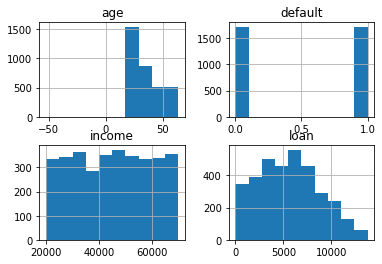

In [3]:
df.hist()

In [4]:
df.dtypes

income     float64
age        float64
loan       float64
default      int64
dtype: object

In [5]:
df.isnull().sum()

income     0
age        0
loan       0
default    0
dtype: int64

No categorical data, thus creating dummy variables is not required. No missing or NaN data in the entire dataset.

In [6]:
df.describe()

,income,age,loan,default
count,3428.000000,3428.000000,3428.000000,3428.000000
mean,45136.875975,34.795950,5591.986695,0.500000
std,14425.486619,12.840055,3174.522430,0.500073
min,20014.489470,-52.423280,1.377630,0.000000
25%,32827.211177,25.171939,3103.357467,0.000000
50%,45546.632873,30.086842,5540.305046,0.500000
75%,57514.794130,44.369461,7809.377943,1.000000
max,69995.685580,63.971796,13766.051240,1.000000


Here we notice that age has a negatve minimum value.

In [7]:
df.sort_values('age')

,income,age,loan,default
21,32197.62070,-52.423280,4244.057136,0
26,63287.03891,-36.496976,9595.286289,0
15,50501.72669,-28.218361,3977.287432,0
1749,67119.13596,18.055189,2725.240313,0
1680,29856.48632,18.055874,4731.816864,1
...,...,...,...,...
931,45783.15475,63.885044,7492.909820,0
1848,40522.82828,63.887141,7720.780489,0
401,62553.66841,63.924976,4641.704785,0
939,29178.97759,63.930735,1664.386062,0


A negative age value may suggest the true value despite being invalid. For example, an age value of -52 could be actually 52 due to a typo mistake. Thus, based on this assumption, we will convert the negative values to their positive representations.

In [8]:
df['age'] = df['age'].abs()

In [9]:
df.describe()

,income,age,loan,default
count,3428.000000,3428.000000,3428.000000,3428.000000
mean,45136.875975,34.864292,5591.986695,0.500000
std,14425.486619,12.653256,3174.522430,0.500073
min,20014.489470,18.055189,1.377630,0.000000
25%,32827.211177,25.187842,3103.357467,0.000000
50%,45546.632873,30.107024,5540.305046,0.500000
75%,57514.794130,44.387971,7809.377943,1.000000
max,69995.685580,63.971796,13766.051240,1.000000


#### Normalisation

Normalisation refers to rescaling by the minimum and range of the vector, to make all the elements lie between 0 and 1 thus bringing all the values of numeric columns in the dataset to a common scale.

As seen from the dataset, the features have different ranges, where age ranges from 0–100 and income ranges from 20000-60000. Thus, income is about 600 times larger than age. So, these two features are in very different ranges. When we do further analysis, like multivariate linear regression, for example, the attributed income will intrinsically influence the result more due to its larger value. But this doesn’t necessarily mean it is more important as a predictor. So we normalize the data to bring all the variables to the same range by using MinMaxScalar.

In [10]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names = df.columns
print(names)
d = scaler.fit_transform(df)
df = pd.DataFrame(d, columns=names)
df.head()

Index(['income', 'age', 'loan', 'default'], dtype='object')


,income,age,loan,default
0,0.923176,0.892092,0.588837,0.0
1,0.288122,0.654708,0.476827,0.0
2,0.746334,0.981189,0.582620,0.0
3,0.454072,0.603198,0.443328,0.0
4,0.939117,0.011524,0.637045,1.0


#### Check for collinearity

In [11]:
X = df.loc[:,['income', 'age', 'loan']]
Y = df.loc[:,"default"]

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

  feature       VIF
0  income  5.615627
1     age  1.883363
2    loan  4.851633


VIF values for the independent variables are not high, indicating that there is low collinearity between them.

#### Distribution of Default values

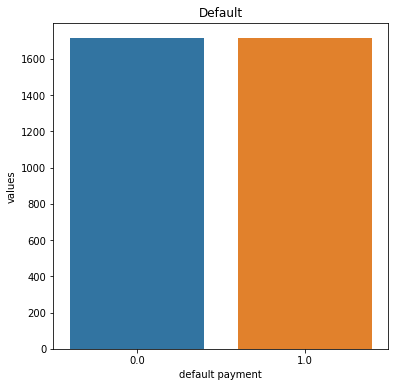

1.0    1714
0.0    1714
Name: default, dtype: int64


In [13]:
temp = Y.value_counts()
default = pd.DataFrame({'default payment': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default')
sb.set_color_codes("pastel")
sb.barplot(x = 'default payment', y="values", data=default)
locs, labels = plt.xticks()
plt.show()
print(temp)

A number of 1714 out of 3428 (or 50%) of clients will default next month. The data has appears to be balanced with respect of the target value (default payment next month).

### Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state = 2)

### Models

#### Logistic Regression

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR_model=LogisticRegression()
LR_model.fit(X_train, Y_train)

LogisticRegression()

0.9495623176323468


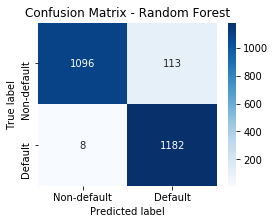

In [16]:
pred=LR_model.predict(X_train)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_train,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

0.9455782312925171


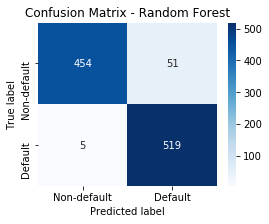

In [17]:
pred = LR_model.predict(X_test)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_test,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

#### Decision Tree

In [18]:
import math
from sklearn import tree
from sklearn.model_selection import GridSearchCV

DT_model = tree.DecisionTreeClassifier()
grid = GridSearchCV(estimator = DT_model, param_grid = dict(max_depth = [i for i in range(1, 20)], min_samples_split = [i for i in range(3, 20)]))
grid_results = grid.fit(X, Y)
grid_results.best_params_

{'max_depth': 9, 'min_samples_split': 4}

In [19]:
DT_model = tree.DecisionTreeClassifier(max_depth=grid_results.best_params_["max_depth"], min_samples_split=grid_results.best_params_["min_samples_split"])
DT_model.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=4)

0.9979157982492706


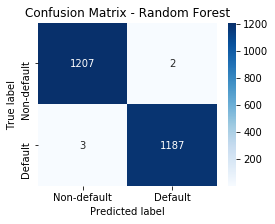

In [20]:
pred = DT_model.predict(X_train)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_train,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

0.9873663751214772


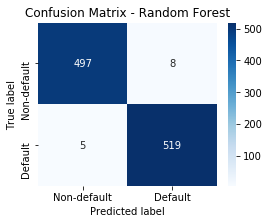

In [21]:
pred = DT_model.predict(X_test)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_test,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

#### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(max_depth=3)
RF_model.fit(X,Y)

RandomForestClassifier(max_depth=3)

0.9499791579824927


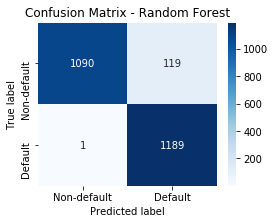

In [23]:
pred = RF_model.predict(X_train)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_train,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

0.9494655004859086


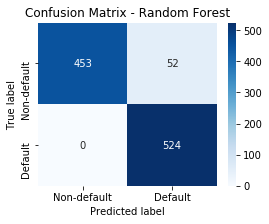

In [24]:
pred = RF_model.predict(X_test)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_test,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

#### XGBoost

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [26]:
XG_model = GradientBoostingClassifier()
grid = GridSearchCV(estimator = XG_model, param_grid = dict(max_depth = [i for i in range(1, 20)]))
grid_results = grid.fit(X, Y)
grid_results.best_params_

{'max_depth': 5}

In [27]:
XG_model = GradientBoostingClassifier(max_depth=grid_results.best_params_["max_depth"])
XG_model.fit(X_train,Y_train)

GradientBoostingClassifier(max_depth=5)

1.0


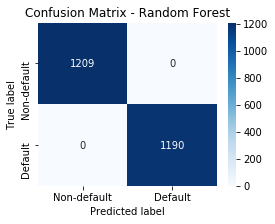

In [28]:
pred = XG_model.predict(X_train)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_train,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

0.9912536443148688


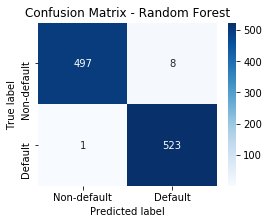

In [29]:
pred = XG_model.predict(X_test)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_test,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

In [30]:
import joblib
joblib.dump(XG_model, "XGBoost")

['XGBoost']

In [31]:
#test
pred = XG_model.predict([[0.9, 0.01, 0.63]])
print(pred)

[1.]


#### Neural Network

In [32]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Dropout

In [33]:
model = Sequential()
model.add(Dense(10, input_dim=3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"])

In [34]:
model.fit(X_train, Y_train, batch_size=10, epochs=10, verbose=1)

Epoch 1/10
240/240 [==============================] - 15s 1ms/step - loss: 0.7176 - accuracy: 0.5133
Epoch 2/10
240/240 [==============================] - 0s 907us/step - loss: 0.6372 - accuracy: 0.7394
Epoch 3/10
240/240 [==============================] - 0s 952us/step - loss: 0.5527 - accuracy: 0.8087
Epoch 4/10
240/240 [==============================] - 0s 947us/step - loss: 0.4831 - accuracy: 0.8390
Epoch 5/10
240/240 [==============================] - 0s 935us/step - loss: 0.4102 - accuracy: 0.8631
Epoch 6/10
240/240 [==============================] - 0s 882us/step - loss: 0.3770 - accuracy: 0.8596
Epoch 7/10
240/240 [==============================] - 0s 842us/step - loss: 0.3451 - accuracy: 0.8699
Epoch 8/10
240/240 [==============================] - 0s 941us/step - loss: 0.3013 - accuracy: 0.8990
Epoch 9/10
240/240 [==============================] - 0s 1ms/step - loss: 0.2881 - accuracy: 0.8915
Epoch 10/10
240/240 [==============================] - 0s 1ms/step - loss: 0.2721 - a

In [35]:
model.evaluate(X_test,Y_test)

33/33 [==============================] - 0s 907us/step - loss: 0.2218 - accuracy: 0.9329


[0.22181092202663422, 0.9329445958137512]

0.9324718632763651


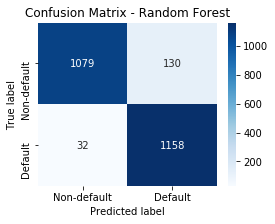

In [36]:
pred = model.predict(X_train)
pred=np.where(pred>0.5,1,0)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_train,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

0.9329446064139941


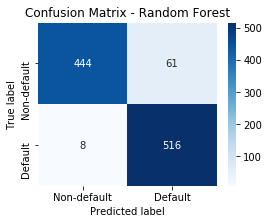

In [37]:
pred = model.predict(X_test)
pred=np.where(pred>0.5,1,0)
plt.figure(figsize=(4,3))
cm = confusion_matrix(Y_test,pred)
sb.heatmap(cm,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print(accuracy)

In [38]:
from keras.models import load_model
model.save("default")

INFO:tensorflow:Assets written to: default\assets
